In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from astropy.constants import c
from scipy.fftpack import fft, fftfreq
c = c.value*1e-6 #Speed of light in mm/ns

In [21]:
datadir = '../data/27-01 150GHz Ypol/'
files = glob(datadir + 'fts_150GHz_201605017_0*.txt') 

In [22]:
def quadratic(x, A, B, C):
    return A*x**2 + B*x + C

In [45]:
spectra = []
phase = []
freqs = []
for f in files[3:]:
    index, time, encoder, signal = np.loadtxt(f, comments='#', skiprows=17, unpack=True)
    encoder /= (c/2)
    
    peak = encoder[np.where(signal == max(signal))[0]][0]
    thresh = np.logical_and(encoder > (peak - 1.5), encoder < (peak + 1.5))
    encoder = encoder[thresh]
    signal = signal[thresh]

    # Remove the dc component as much as we can
    mean = np.average(signal)
    signal -= mean
    
    y = fft(signal)
    d = np.mean(np.diff(encoder))
    n = len(encoder)
    k = fftfreq(n,d)
    spectra += [np.abs(y)[:1450]]
    phase += [np.angle(y)[:1450]]
    freqs += [k[:1450]]
spectra = np.array(spectra)
phase = np.array(phase)
freqs = np.array(freqs)

0.00103481757301
0.00103492346638
0.00103489123796
0.0010348103961
0.00103485183263
0.00103484573902
0.00103478724039
0.00103482136459
0.00103479577144
0.00103483477053
0.00103483720797
0.00103485183263
0.00103491276871
0.00103479577144
0.0010347994276
0.00104024345688


In [40]:
ypol = np.arange(8)
xpol = np.arange(8, 15)

In [41]:
# Average out our spectra to reduce the noise
pol = ypol
nosample = np.average(spectra[pol][::2], axis=0)
nosamplephase = np.average(phase[pol][::2], axis=0)
nosampleerr = np.std(spectra[pol][::2], axis=0)

sample = np.average(spectra[pol][1::2], axis=0)
samplephase = np.average(phase[pol][::2], axis=0)
sampleerr = np.std(spectra[pol][1::2], axis=0)

k = np.average(freqs[pol], axis=0)
kerr = np.std(freqs[pol], axis=0)

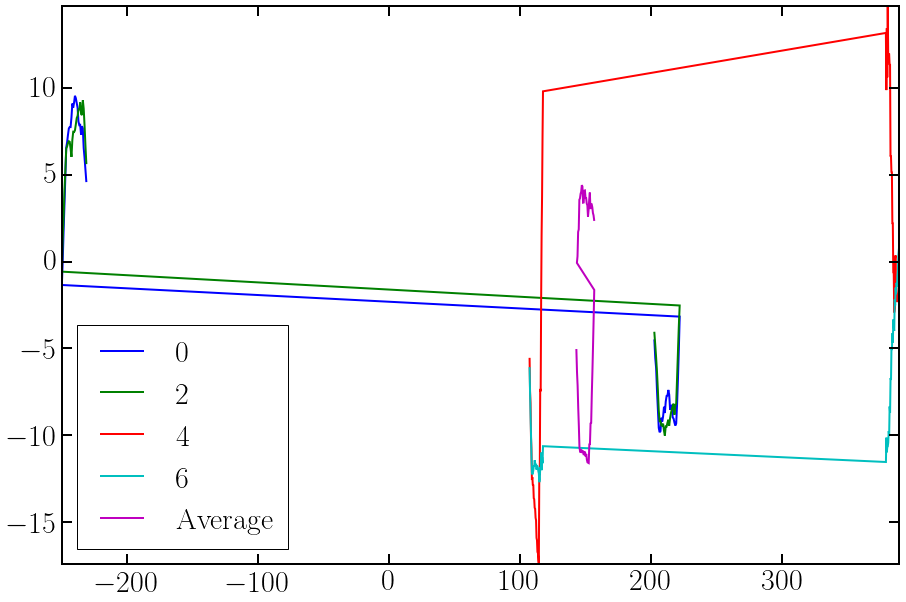

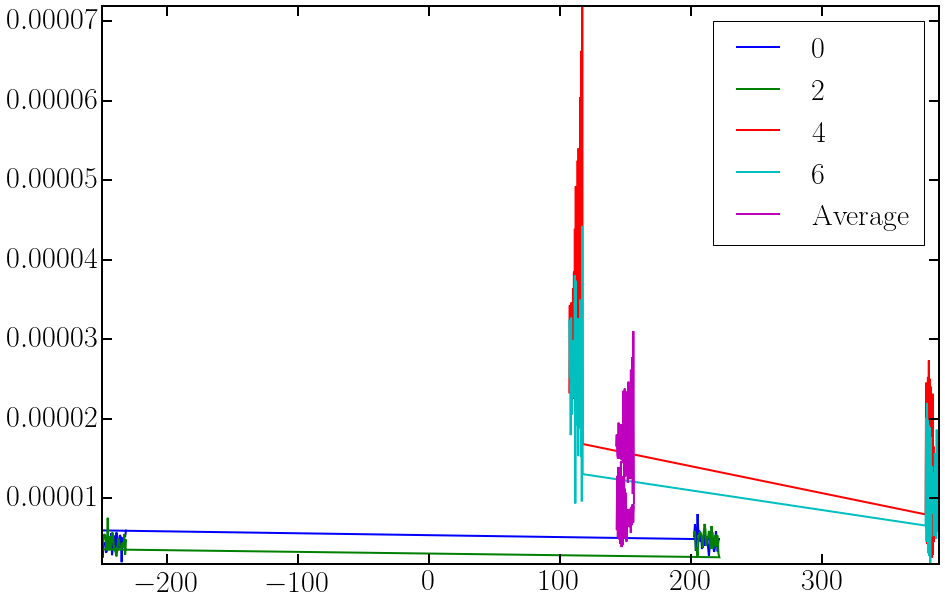

In [44]:
fig, ax = plt.subplots(figsize=(15,10))
thresh = np.logical_and(k > 143, k < 157)
mask = np.ones(10)
for i in xrange(0,7,2):
    ax.plot(freqs[i][thresh], np.convolve(phase[i][thresh], mask, 'same'), label='%d'%i)
#     ax.plot(freqs[i][thresh], phase[i][thresh])
ax.plot(k[thresh], np.convolve(samplephase[thresh], mask, 'same'), label='Average');
ax.legend(loc='best')
ax.axis('tight');

fig, ax = plt.subplots(figsize=(15,10))
for i in xrange(0,7,2):
    ax.plot(freqs[i][thresh], spectra[i][thresh], label='%d'%i)
#     ax.plot(freqs[i][thresh], phase[i][thresh])
ax.plot(k[thresh], nosample[thresh], label='Average');
ax.legend(loc='best')
ax.axis('tight');

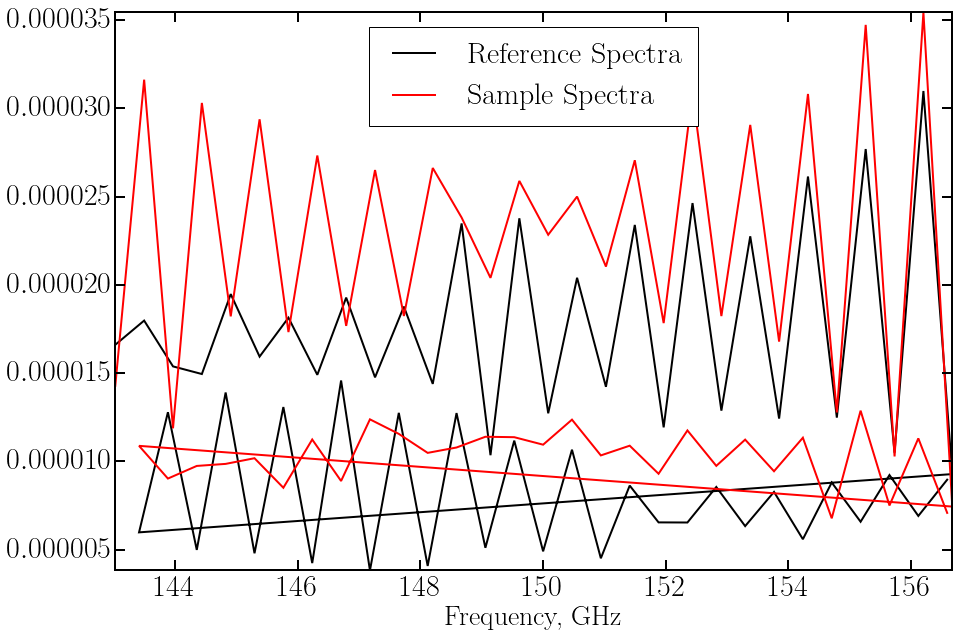

In [38]:
fig, ax = plt.subplots(figsize=(15,10))
# thresh = np.logical_and(k > 140, k < 160)
ax.plot(k[thresh], nosample[thresh],'k', label='Reference Spectra');
ax.plot(k[thresh], sample[thresh],'r', label='Sample Spectra');
ax.axis('tight');
ax.legend(loc='best')
ax.set_xlabel('Frequency, GHz');
plt.savefig('ypolspectra.png')

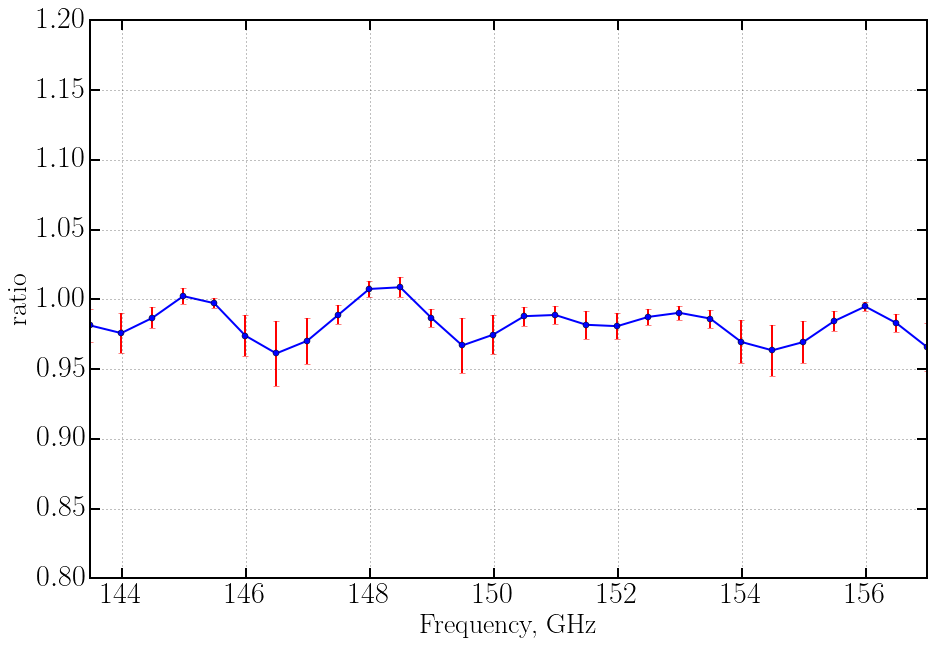

In [35]:
transmission = sample/nosample
scaled_spectrum = nosample/max(nosample)
t_err = transmission * np.sqrt((sampleerr/sample)**2 + (nosampleerr/nosample)**2)
fig, ax =plt.subplots(figsize=(15,10))
ax.errorbar(k[thresh], transmission[thresh], yerr = t_err[thresh], fmt = 'b-o', ecolor='r')
# ax.plot(k[thresh], scaled_spectrum[thresh], 'k--')
ax.grid(which='major')
ax.set_xlabel('Frequency, GHz');
ax.set_ylabel('ratio')
ax.axis('tight');
ax.set_ylim([0.8, 1.2])
plt.savefig('ypoltransmission.png')

In [36]:
#Let's try some interpolation
from scipy import interpolate
f = interpolate.interp1d(k[thresh], transmission[thresh], 'cubic')
kmin = k[thresh][0]
kmax = k[thresh][-1]
k_new = np.r_[kmin:kmax:2*len(k)*1j]
t_new = f(k_new)

In [3]:
fig, ax =plt.subplots(figsize=(15,10))
ax.plot(k_new, t_new,'r', label= 'interpolated FP spectrum')
# ax.errorbar(k[thresh], transmission[thresh], yerr = t_err[thresh], color = 'b')
ax.grid(which='major')
ax.set_xlabel('Frequency, GHz');
ax.set_ylabel('Transmission')
ax.axis('tight');
from peakdetect import peakdetect
max_peaks, min_peaks = peakdetect(t_new, k_new)
loc, val = map(list, zip(*max_peaks))
ax.plot(loc, val, 'bd', markersize=5, label='peaks');
ax.legend(loc='best');
plt.savefig('ypolinterpolated.png')

NameError: name 'k_new' is not defined

In [4]:
absorption = 1 - np.array(val)
fig, ax =plt.subplots(figsize=(15,10))
ax.plot(loc, absorption,'r.', markersize=10);
f = interpolate.interp1d(loc, absorption, 'cubic')
loc_new = np.r_[loc[0]:loc[-1]:2*len(loc)*1j]
absorption_new = f(loc_new)
ax.plot(loc_new, absorption_new,'k');

NameError: name 'val' is not defined

In [39]:
L = 2.25*25.4 # thickness of the etalon in mm
from scipy.optimize import curve_fit

def get_transmission(nu, y, F, A, B):
    return y*(1 - F * (1 - np.cos(A*nu + B))/2)

R = 0.00207
F = 4*R/(1-R)**2
A = 4*np.pi*L/c
B = np.pi
y = np.average(val)
guesses = [y, F, A, B]
popt, pcov = curve_fit(get_transmission, k[thresh], transmission[thresh], p0=guesses, sigma=t_err[thresh])
# popt, pcov = curve_fit(get_transmission, k_new, t_new, p0=guesses)
perr =np.sqrt(np.diag(pcov))
print popt, perr

[ 0.9960701   0.01892497  2.38249911  5.53984463] [  1.78076215e-03   4.43604595e-03   5.91586506e-02   8.90172600e+00]


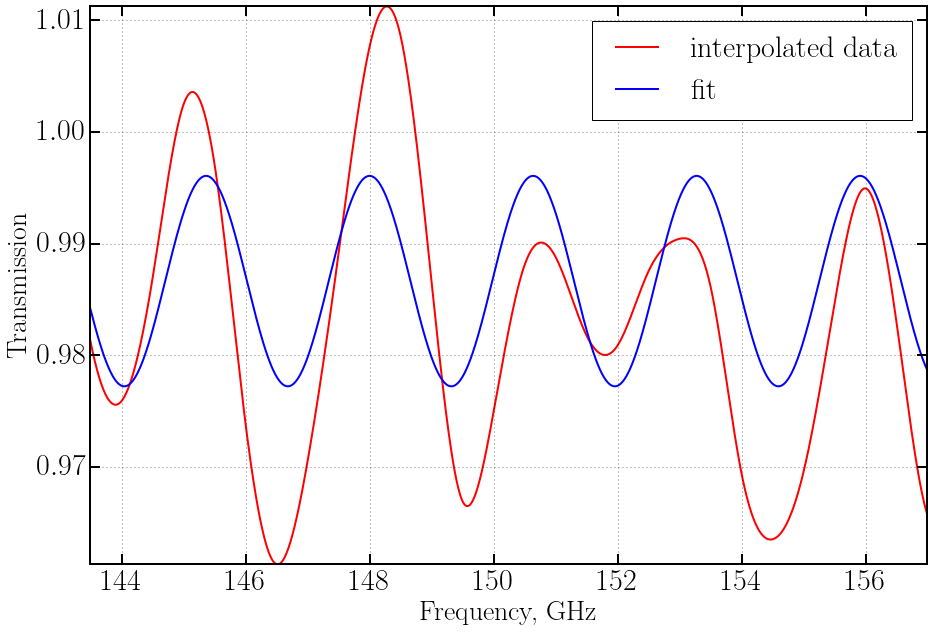

In [40]:
fig, ax =plt.subplots(figsize=(15,10))
# ax.plot(k[thresh], transmission[thresh], 'r-', markersize=10)
ax.plot(k_new, t_new,'r', label='interpolated data')
# ax.errorbar(k[thresh], transmission[thresh], yerr = t_err[thresh], fmt = 'r-o',label='data')
ax.plot(k_new, get_transmission(k_new, *popt), 'b', label='fit')
ax.grid(which='major')
ax.set_xlabel('Frequency, GHz');
ax.set_ylabel('Transmission')
ax.axis('tight');
ax.legend(loc='best');
plt.savefig('ypolinterpolatedfit.png')

In [41]:
y, F, a, b = popt[0], popt[1], popt[2], popt[3]
sigy, sigF, siga, sigb = perr[0], perr[1], perr[2], perr[3]

In [42]:
A = (1 - F/4)*(1 - np.sqrt(y))
T = (1 - F/4)*(np.sqrt(y))

In [43]:
sigA = A*np.sqrt((sigy/(2*y**0.5*(1-y**0.5)))**2 + (sigF/(4*(1-F/4)))**2)
sigT = T*np.sqrt((sigy/(2*y))**2 + (sigF/(4*(1-F/4)))**2)

In [44]:
print A, sigA
print T, sigT

0.00195757665113 0.000887917569412
0.993311180279 0.00141896649953


In [45]:
R = (2 + F - 2*(1+F)**0.5)/F
sigR = R/(F*(1+F)**0.5)*sigF
print R, sigR

0.00468699636707 0.00108838938596


In [46]:
ypol

array([0, 1, 2, 3, 4, 5, 6, 7])

In [47]:
R = 1-(T+A)
print R

0.00473124306961


In [ ]:
4*R/(1-R)**2

In [ ]:
F

In [ ]:
4*R*(1+ 2*R)

In [ ]:
4*R

In [ ]:
F/4

In [ ]:
curve_fit?

In [ ]:
range(1,7,2)

In [ ]:
np.mod(5,3)

In [ ]:
np.angle?

In [ ]:
np.arange(8)

In [ ]:
np.arange(8, 15)